In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from ShallowTree.ShallowTree import ShallowTree as ShallowTree_
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.selection import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

In [6]:
from pyarc import TransactionDB

In [42]:
CBA

intercluster.decision_sets.cba.CBA

In [7]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

color_dict = {
    0: cmap(1),
    1: cmap(5),
    2: cmap(7),
    3: cmap(6),
    4: cmap(3),
    5: cmap(2),
    6: cmap(4),
    7: cmap(0)
}
color_dict[-1] = 'grey'

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (although this will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

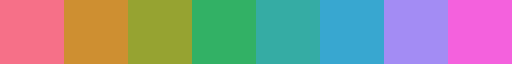

In [8]:
cmap

## Example Setting

The following notebook is intended to work with a simple setting in which the methods and 
algorithms for this library may be tested and experimented with. 

In [9]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [10]:
n = 1000
m = 2
k = 4

cluster_centers = np.array([
    [0,1],
    [0.25, 0.25],
    [0.9, 0.75],
    #[1.55,0.1],
])

data, labels = datasets.make_blobs(
    n_samples=n, centers = cluster_centers, cluster_std=0.125, random_state=seed
)

# Outliers:
data = np.vstack((data, np.array([[0.25,3.5],[0.75,3.5]])))
labels = np.hstack((labels, np.array([3,3])))

Text(0, 0.5, 'y')

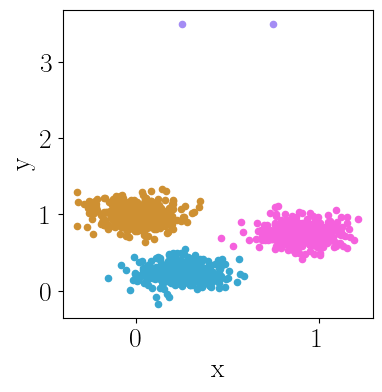

In [11]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(labels)
for l in uni_labels:
    idx = np.where(labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [18]:
# KMeans
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)

In [19]:
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)

Text(0, 0.5, '$x_2$')

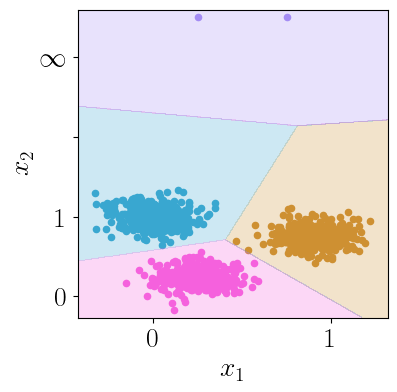

In [20]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
uni_labels = np.unique(kmeans.labels_)
for l in uni_labels:
    idx = np.where(kmeans.labels_ == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)

plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000, label_array = True, color_dict = color_dict)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#plt.savefig('../figures/examples/outliers_kmeans.png', bbox_inches = 'tight')

In [65]:
n_rules = 4

# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, kmeans_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = k, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# IMM
imm_tree = ExkmcTree(k = k, kmeans = kmeans, max_leaf_nodes = n_rules)
imm_tree.fit(data)
imm_labels = imm_tree.predict(data, leaf_labels = False)
imm_labels_ = flatten_labels(imm_labels)
imm_leaf_labels = imm_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
imm_rule_assignment = labels_to_assignment(imm_leaf_labels, n_labels = k, ignore = {-1})
imm_data_to_rule_assignment = imm_tree.get_data_to_rules_assignment(data)
imm_data_to_cluster_assignment = imm_data_to_rule_assignment @ imm_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = k)
rem_tree.fit(data, kmeans_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = k, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
#rule_miner = PointwiseMiner(samples = 10, prob_dim = 1/2, prob_mistake = 0.0)
rule_miner = ClassAssociationMiner(min_support = 0.0, min_confidence = 0.0)
dsclust = DSCluster(lambd = 100, n_rules = n_rules, rule_miner = rule_miner)
dsclust.fit(data, kmeans_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = k, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

cba = CBA(rule_miner = rule_miner)
cba.fit(data, kmeans_labels)
cba_labels = cba.predict(data)
cba_labels_ = flatten_labels(cba_labels)
cba_rule_assignment = labels_to_assignment(cba.decision_set_labels, n_labels = k, ignore = {-1})
cba_data_to_rule_assignment = cba.get_data_to_rules_assignment(data)
cba_data_to_cluster_assignment = cba_data_to_rule_assignment @ cba_rule_assignment


In [11]:
n_mine = 20

lambdas = [
    1/n_mine,
    1/(2 * data.shape[1] * n_mine),
    1/(len(data) * (n_mine**2)),
    1/(len(data) * (n_mine**2)),
    k,
    1/(data.shape[0] * n_mine),
    1/(data.shape[0])
]


rule_miner = AssociationRuleMiner(max_rules = n_mine)
ids_set = IdsSet(lambdas = lambdas, rule_miner = rule_miner)
ids_set.fit(data, kmeans_labels)
ids_set_labels = ids_set.predict(data)
#ids_set_labels_ = flatten_labels(ids_set_labels)
ids_set_labels_ = np.array([min(labs) for labs in ids_set_labels])
ids_set_rule_assignment = labels_to_assignment(ids_set.decision_set_labels, n_labels = k, ignore = {-1})
ids_set_data_to_rule_assignment = ids_set.get_data_to_rules_assignment(data)
ids_set_data_to_cluster_assignment = ids_set_data_to_rule_assignment @ ids_set_rule_assignment

Lambdas found: [0.05, 0.0125, 2.4950099800399203e-06, 2.4950099800399203e-06, 4, 4.99001996007984e-05, 0.000998003992015968]


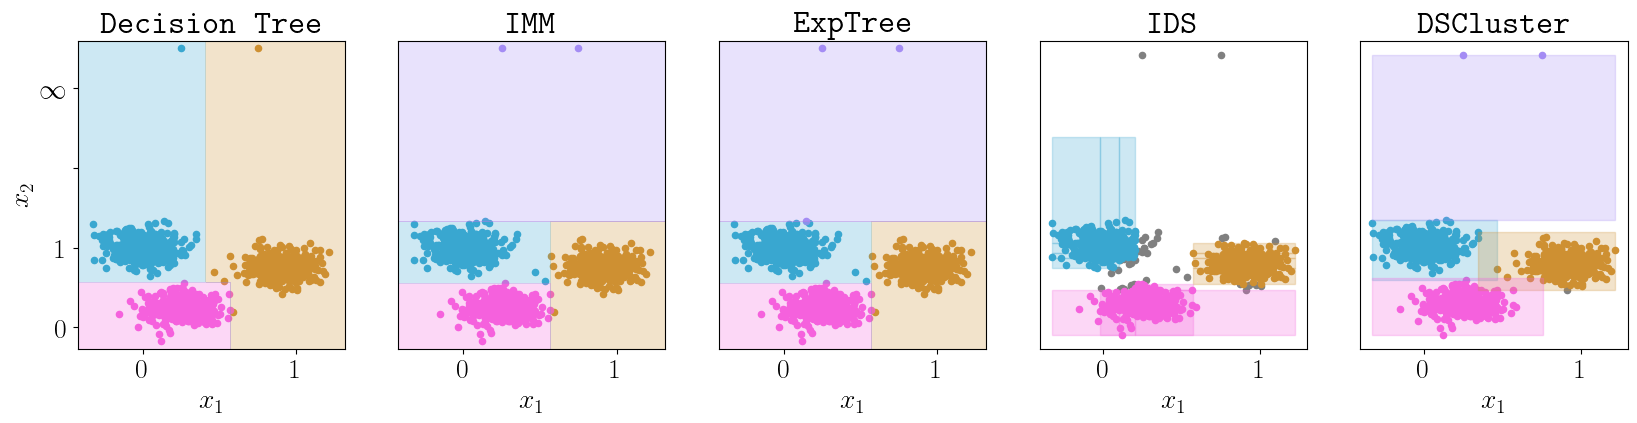

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4), dpi = 100)

# Decision Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(dtree_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(dtree, data, color_dict, ax = axs[0], resolution = 1000, label_array = False)
axs[0].set_xlabel(r'$x_1$')
axs[0].set_title(r"\texttt{Decision Tree}")

# IMM
uniqie_labs = np.unique(imm_labels_)
for l in uniqie_labs:
    idx = np.where(imm_labels_ == l)[0]
    axs[1].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(imm_tree, data, color_dict, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel(r'$x_1$')
axs[1].set_title(r"\texttt{IMM}")

# Removal Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(rem_tree_labels_ == l)[0]
    axs[2].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(rem_tree, data, color_dict, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel(r'$x_1$')
axs[2].set_title(r"\texttt{ExpTree}")

# IDS
uniqie_labs = np.unique(ids_set_labels_)
for l in uniqie_labs:
    idx = np.where(ids_set_labels_ == l)[0]
    axs[3].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(ids_set, data, color_dict, axs[3])
axs[3].set_xlabel(r'$x_1$')
axs[3].set_title(r"\texttt{IDS}")

# Decision Set Clustering
uniqie_labs = np.unique(dsclust_labels_)
for l in uniqie_labs:
    idx = np.where(dsclust_labels_ == l)[0]
    axs[4].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(dsclust, data, color_dict, axs[4])
axs[4].set_xlabel(r'$x_1$')
axs[4].set_title(r"\texttt{DSCluster}")


y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
axs[0].set_yticks(y_tick_locations)
axs[0].set_yticklabels(y_tick_labels)
axs[0].set_ylabel(r'$x_2$')

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)
axs[4].yaxis.set_visible(False)

#plt.savefig("../figures/examples/counter_example.png", bbox_inches = 'tight', dpi = 300)

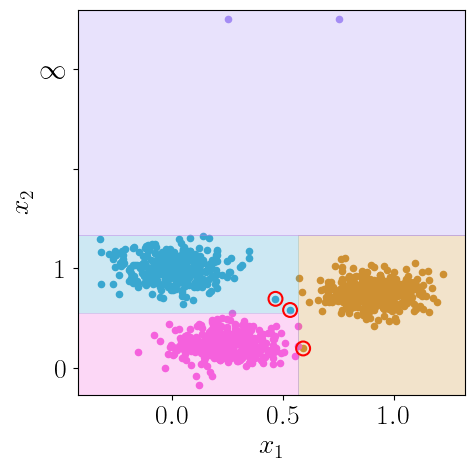

In [13]:
algname = "removal_tree"
alg = rem_tree
alg_labels = rem_tree_labels_
title = r"\texttt{ExpTree}"

fig,ax = plt.subplots(figsize = (5,5), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(alg, data, color_dict, ax = ax, resolution = 1000, label_array = False)

# Mark misclassified points
misclassified = np.where(alg_labels != kmeans_labels_)[0]
ax.scatter(data[misclassified,0], data[misclassified,1], facecolors = 'none', edgecolors = 'red', s = 100, linewidths = 1.5)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)


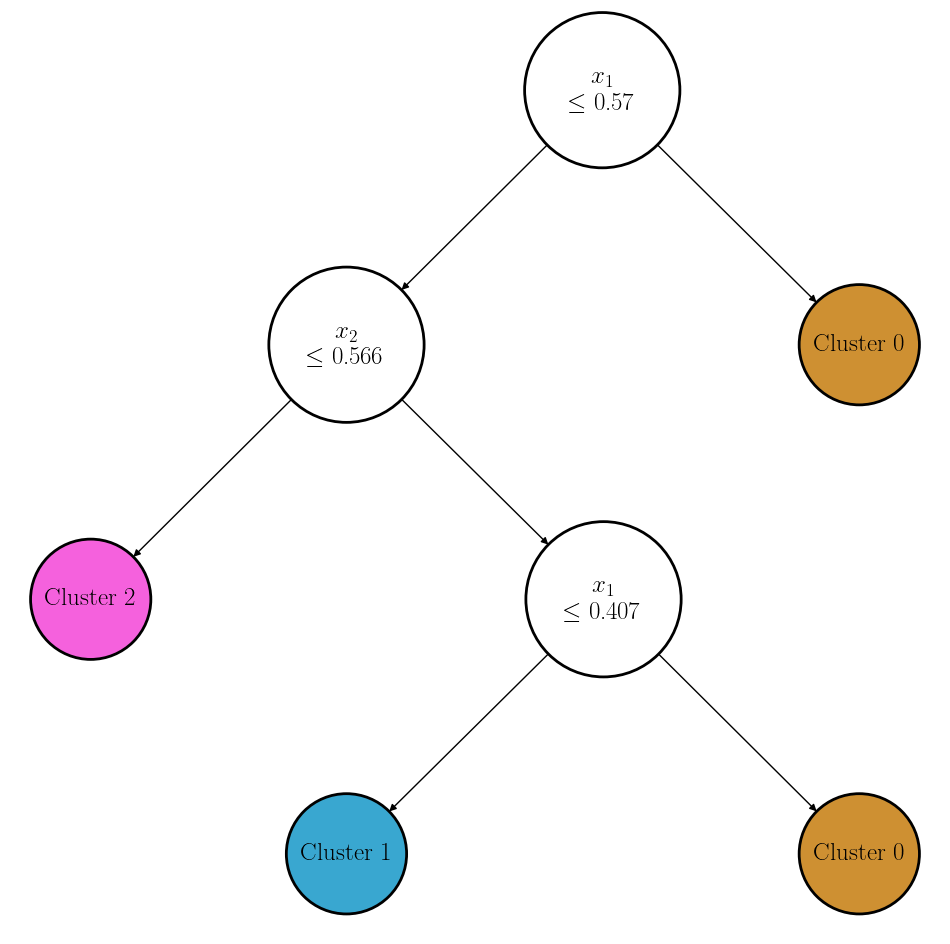

In [44]:
draw_tree(
    root = alg.root,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    output_file = "../figures/examples/outliers/" + algname + "_rules.png"
)

IndexError: index 1003 is out of bounds for axis 0 with size 1002

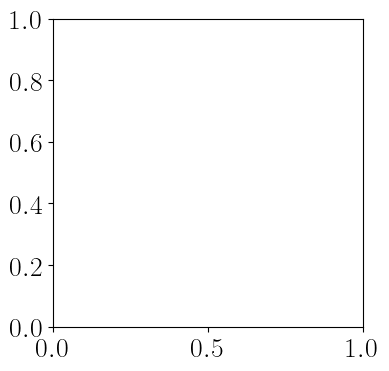

In [66]:
algname = "cba"
alg = cba
alg_labels = cba_labels_
#title = r"\texttt{IDS}"

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(alg, data, color_dict, ax)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
#plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)

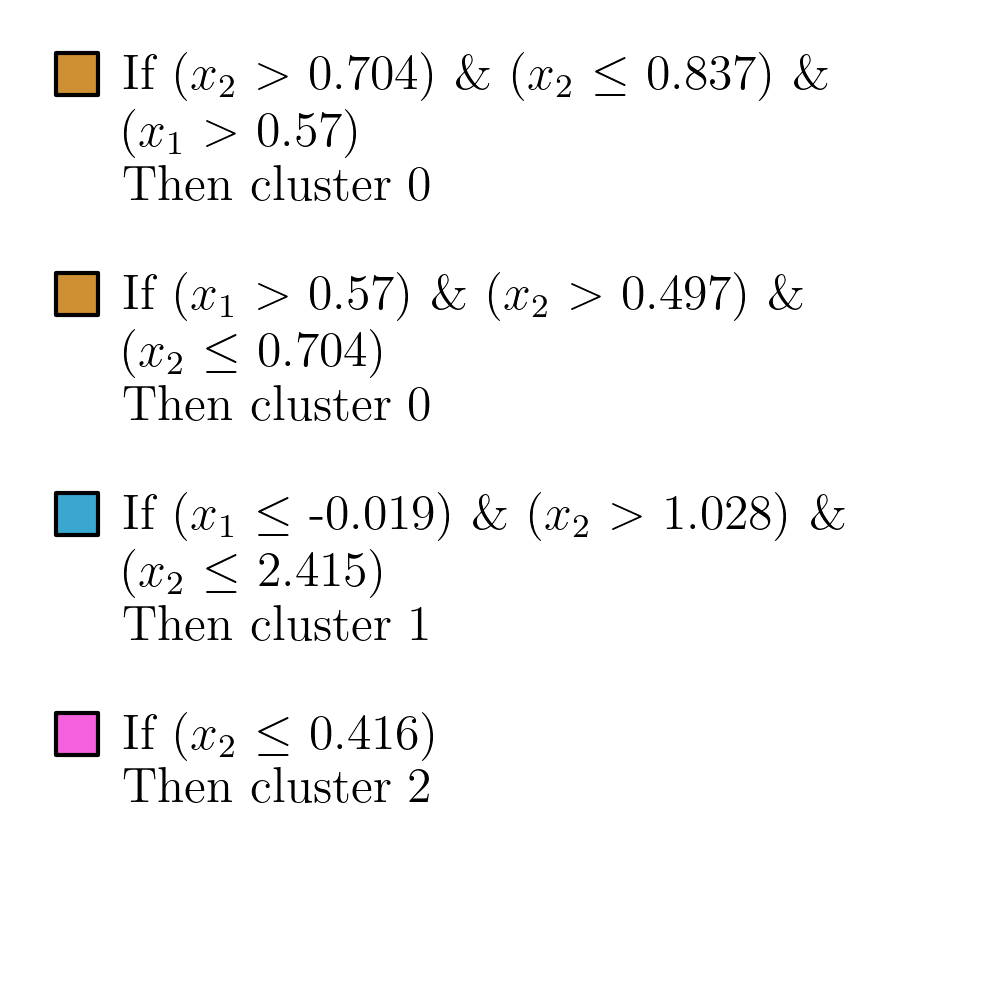

In [40]:
plot_decision_set(
    decision_set = alg.decision_set,
    rule_labels = alg.decision_set_labels,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    size_factor = 1,
    #filename = "../figures/examples/outliers/" + algname + "_rules.png",
)

### DBSCAN Example

In [17]:
from typing import Set, Any, List
from itertools import combinations
import math

In [18]:
def clustering_to_labeling(U : Set[int], cluster_dict : dict[Any, Set[int]]) -> dict[int, Set[int]]:
    labeling = {u : set() for u in U}
    for (key, value) in cluster_dict.items():
        for v in value:
            labeling[v].add(key)
    return labeling


def rules_to_labeling(U : Set[int], rule_dict : dict[Any, Set[int]], rule_assignment_dict) -> dict[int, Set[Any]]:
    labeling = {u : set() for u in U}
    for (rule, points_covered) in rule_dict.items():
        assigned_clusters = rule_assignment_dict[rule]
        for v in points_covered:
            labeling[v].update(assigned_clusters)
    return labeling

def get_rule_subset(rules : List[Any], rule_dict : dict[Any, Set[int]]) -> dict[Any, Set[int]]:
    subset = {rule : rule_dict[rule] for rule in rules if rule in rule_dict}
    return subset

In [127]:
def pairwise_distance(U : Set[int], clustering : dict[Any, Set[int]], rules: dict[Any, Set[int]], rule_assignment : dict[Any, Set[int]]) -> float:
    cluster_labeling = clustering_to_labeling(U, clustering)
    rule_labeling = rules_to_labeling(U, rules, rule_assignment)
    total = 0.0
    for (x, y) in combinations(U, 2):
        total += abs(
            len(cluster_labeling[x].intersection(cluster_labeling[y])) - 
            len(rule_labeling[x].intersection(rule_labeling[y]))
        )
    return total


def coverage(U : Set[int], clustering : dict[Any, Set[int]], rules: dict[Any, Set[int]], rule_assignment : dict[Any, Set[int]]) -> float:
    covered_dict = {cluster : set() for cluster in clustering.keys()}
    for cluster in clustering.keys():
        points_in_cluster = clustering[cluster]
        for rule in rules.keys():
            if cluster in rule_assignment[rule]:
                covered_dict[cluster].update(rules[rule].intersection(points_in_cluster))
    
    total = sum([math.comb(len(covered_dict[cluster]), 2) for cluster in covered_dict.keys()])
    return total
        

def mistakes(U : Set[int], clustering : dict[Any, Set[int]], rules: dict[Any, Set[int]], rule_assignment : dict[Any, Set[int]]) -> float:
    cluster_labeling = clustering_to_labeling(U, clustering)
    total = 0.0
    for rule in rules.keys():
        points_covered = rules[rule]
        #for (x, y) in combinations(points_covered, 2):
            #if cluster_labeling[x].intersection(cluster_labeling[y]) == set():
                #total += 1.0
        for (x,y) in combinations(U, 2):
            if x in points_covered and y in points_covered:
                if cluster_labeling[x].intersection(cluster_labeling[y]) == set():
                    total += 1.0
            elif x in points_covered or y in points_covered:
                if cluster_labeling[x].intersection(cluster_labeling[y]) != set():
                    total += 1.0
    return total

    

def coverage_mistake_score(U : Set[int], clustering : dict[Any, Set[int]], rules: dict[Any, Set[int]], rule_assignment : dict[Any, Set[int]]) -> float:
    return coverage(U, clustering, rules, rule_assignment) - mistakes(U, clustering, rules, rule_assignment)

In [134]:
U = {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15}

clustering = {
    0: {1,2,3,4,5,6,7,8,9,10},
    1: {11,12},
    2: {13,14,15}
}

rules = {
    'A': {1,2},
    'B': {8,9,10},
    'C': {11,12},
    'D': {10,13,14,15},
    'E': {14,15},
    'F': {11,12,13,14,15}
}

rule_assignment = {
    'A': {0},
    'B': {0},
    'C': {1},
    'D': {2},
    'E': {2},
    'F': {2}
}


# Generate random rules:
rules = {
    'A': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False)),
    'B': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False)),
    'C': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False)),
    'D': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False)),
    'E': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False)),
    'F': set(np.random.choice(list(U), size = np.random.choice(range(1, len(U))), replace = False))
}

# assign each rule to a random cluster
rule_assignment = {
    'A': {np.random.choice(list(clustering.keys()))},
    'B': {np.random.choice(list(clustering.keys()))},
    'C': {np.random.choice(list(clustering.keys()))},
    'D': {np.random.choice(list(clustering.keys()))},
    'E': {np.random.choice(list(clustering.keys()))},
    'F': {np.random.choice(list(clustering.keys()))}
}

cluster_labeling = clustering_to_labeling(U, clustering)
rule_labeling = rules_to_labeling(U, rules, rule_assignment)

In [144]:
rules

{'A': {1, 3, 4, 7, 9, 10, 13, 14, 15},
 'B': {3, 14, 15},
 'C': {3, 10, 11, 12},
 'D': {5, 14},
 'E': {3, 4, 6, 9, 13, 14},
 'F': {1, 2, 6, 7, 9, 11, 14, 15}}

In [145]:
rule_assignment

{'A': {0}, 'B': {2}, 'C': {0}, 'D': {0}, 'E': {0}, 'F': {1}}

In [147]:
cluster_labeling

{1: {0},
 2: {0},
 3: {0},
 4: {0},
 5: {0},
 6: {0},
 7: {0},
 8: {0},
 9: {0},
 10: {0},
 11: {1},
 12: {1},
 13: {2},
 14: {2},
 15: {2}}

In [146]:
rule_labeling

{1: {0, 1},
 2: {1},
 3: {0, 2},
 4: {0},
 5: {0},
 6: {0, 1},
 7: {0, 1},
 8: set(),
 9: {0, 1},
 10: {0},
 11: {0, 1},
 12: {0},
 13: {0},
 14: {0, 1, 2},
 15: {0, 1, 2}}

In [136]:
size = 3
rule_subsets = combinations(rules.keys(), size)

best_pairwise = []
best_pairwise_score = float('inf')
best_coverage_mistake = []
best_coverage_mistake_score = -float('inf')

for rule_subset in rule_subsets:
    rule_subset_dict = get_rule_subset(rule_subset, rules)
    pairwise = pairwise_distance(U, clustering, rule_subset_dict, rule_assignment)
    coverage_mistake = coverage_mistake_score(U, clustering, rule_subset_dict, rule_assignment)
    if pairwise < best_pairwise_score:
        best_pairwise_score = pairwise
        best_pairwise = [rule_subset]
    elif pairwise == best_pairwise_score:
        best_pairwise.append(rule_subset)
    if coverage_mistake > best_coverage_mistake_score:
        best_coverage_mistake_score = coverage_mistake
        best_coverage_mistake = [rule_subset]
    elif coverage_mistake == best_coverage_mistake_score:
        best_coverage_mistake.append(rule_subset)

In [137]:
best_pairwise

[('A', 'D', 'E')]

In [138]:
best_pairwise_score

42.0

In [139]:
best_coverage_mistake

[('B', 'C', 'D')]

In [140]:
best_coverage_mistake_score

-41.0

In [141]:
rule_subset_dict = get_rule_subset(['A', 'D', 'E'], rules)
pairwise = pairwise_distance(U, clustering, rule_subset_dict, rule_assignment)
coverage_mistake = coverage_mistake_score(U, clustering, rule_subset_dict, rule_assignment)

In [142]:
pairwise

42.0

In [143]:
coverage_mistake

-60.0